Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

Load data

In [2]:
df = pd.read_csv("HR_data.csv")
print(df.shape)
df.head()
df['Frustrated'].describe()  # tjekker spread


(168, 13)


count    168.000000
mean       2.291667
std        1.924796
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        8.000000
Name: Frustrated, dtype: float64

In [3]:
groups = df['Individual']
unique_subjects = groups.nunique()

print(unique_subjects)


14


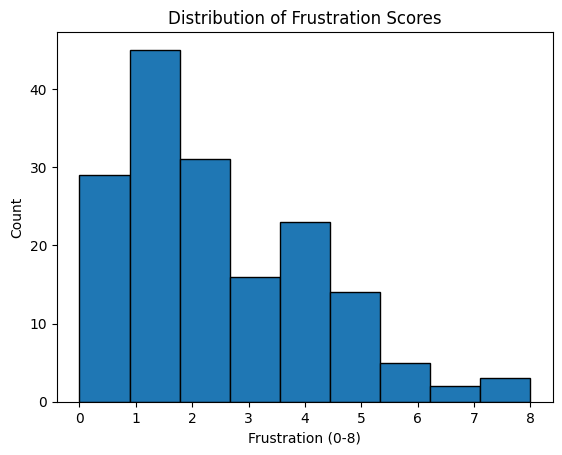

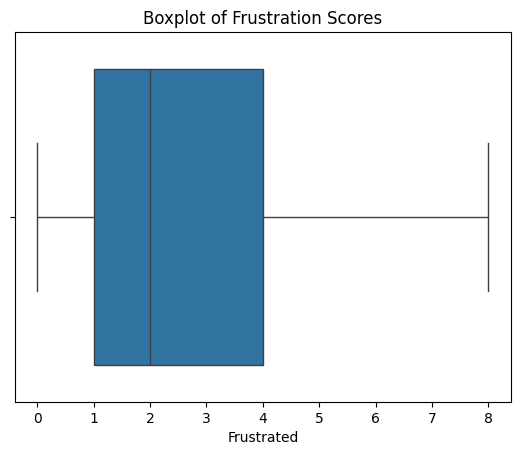

In [4]:
import matplotlib.pyplot as plt

plt.hist(df['Frustrated'], bins=9, edgecolor='black')
plt.title("Distribution of Frustration Scores")
plt.xlabel("Frustration (0-8)")
plt.ylabel("Count")
plt.show()
import seaborn as sns

sns.boxplot(x=df['Frustrated'])
plt.title("Boxplot of Frustration Scores")
plt.show()


Regression path

In [5]:
y  = df['Frustrated'].astype(float)
metrics = {'MAE': mean_absolute_error,
           'RMSE': lambda y, yhat: mean_squared_error(y, yhat, squared=False)}

# Bruger alle undtagen frustrated og individual
# X = df.drop(columns=['Frustrated', 'Individual'])

# Kun med Heart rate
X = df[['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']]

In [6]:
num_cols = [c for c in df.columns if c.startswith('HR_')]

Models

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor 

preprocess = StandardScaler() # normaliserer

# Model 1 - Ridge regression 
ridge = Pipeline([
    ('scale', preprocess),
    ('model', Ridge(alpha=1.0))
])



In [8]:
# Model 2 — Random Forest
rf = Pipeline([
    ('scale', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=2,
        random_state=42))
])

Cross validation

In [9]:
from sklearn.model_selection import GroupKFold, cross_val_score

outer_cv = GroupKFold(n_splits=unique_subjects) # Outer CV loop as leave-one-subject-out

scores_ridge = cross_val_score(ridge, X, y,
                               cv=outer_cv, groups=groups,
                               scoring='neg_mean_absolute_error')

scores_rf = cross_val_score(rf, X, y,
                               cv=outer_cv, groups=groups,
                               scoring='neg_mean_absolute_error')

print(scores_ridge)
print(scores_rf)


[-2.30820477 -1.77259888 -1.92881326 -1.30402627 -1.91642333 -2.05990371
 -0.83922555 -1.51860387 -2.31809044 -1.39226964 -1.46126847 -1.13004787
 -1.27796991 -1.92148957]
[-2.30059773 -2.03736642 -1.90556811 -1.14505438 -1.44010562 -2.37454133
 -1.31425135 -1.71076736 -2.24917884 -1.24855332 -1.09349652 -0.98220459
 -1.58904209 -2.14442599]


Collect and compare per-subject scores

In [10]:
results = pd.DataFrame({
        'subject': np.unique(groups),
        'ridge_MAE': -scores_ridge,
        'rf_MAE':    -scores_rf
})

grouped = df.groupby('Individual')['Frustrated'].mean()
df['PredictedMean'] = df['Individual'].map(grouped)

mae_per_subject = df.groupby('Individual').apply(
    lambda g: (g['Frustrated'] - g['PredictedMean']).abs().mean()
)

results['baseline_MAE'] = mae_per_subject.values

ridge_mean = results['ridge_MAE'].mean()
ridge_std  = results['ridge_MAE'].std()
rf_mean    = results['rf_MAE'].mean()
rf_std     = results['rf_MAE'].std()
baseline_mean = results['baseline_MAE'].mean()
baseline_std  = results['baseline_MAE'].std()

print("ridge:", ridge_mean, "+-", ridge_std)
print("random forest:", rf_mean, "+-", rf_std)
print("baseline:", baseline_mean, "+-", baseline_std)

ridge: 1.6534953960612404 +- 0.44635297874240154
random forest: 1.6810824033222251 +- 0.487499093676523
baseline: 1.4027777777777781 +- 0.549621081594705


/var/folders/3k/tvll7k3j27n95_vhpqrkmc980000gn/T/ipykernel_3114/2987741566.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_subject = df.groupby('Individual').apply(


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

results = pd.DataFrame({
    'subject': np.unique(groups),
    'ridge_MAE': -scores_ridge,
    'rf_MAE':    -scores_rf
})

baseline_maes = []

for train_idx, test_idx in outer_cv.split(X, y, groups):
    # Split i træning og test
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Gætter mean for testsættet
    baseline_pred = [y_train.mean()] * len(y_test)
    
    # Mae udregning
    mae = mean_absolute_error(y_test, baseline_pred)
    baseline_maes.append(mae)


results['baseline_MAE'] = baseline_maes


ridge_mean = results['ridge_MAE'].mean()
ridge_std  = results['ridge_MAE'].std()
rf_mean    = results['rf_MAE'].mean()
rf_std     = results['rf_MAE'].std()
baseline_mean = results['baseline_MAE'].mean()
baseline_std  = results['baseline_MAE'].std()

print("ridge:", ridge_mean, "+-", ridge_std)
print("random forest:", rf_mean, "+-", rf_std)
print("baseline:", baseline_mean, "+-", baseline_std)


ridge: 1.6534953960612404 +- 0.44635297874240154
random forest: 1.6810824033222251 +- 0.487499093676523
baseline: 1.6108821733821734 +- 0.45289553293535667


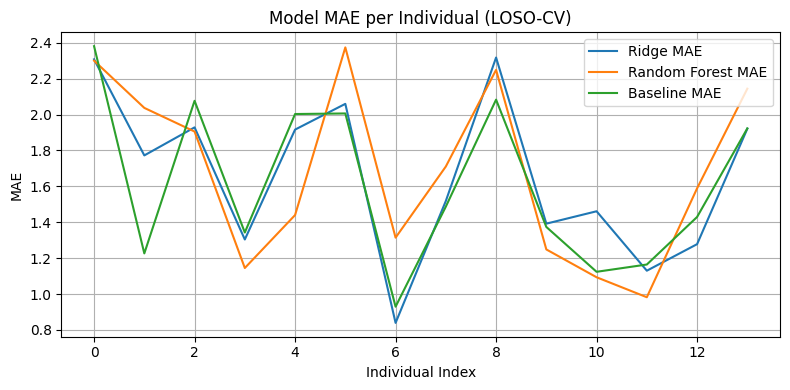

In [21]:
baseline_mae = results['baseline_MAE'].values
ridge_mae = -scores_ridge
rf_mae = -scores_rf

plt.figure(figsize=(8, 4))
plt.plot(ridge_mae, label='Ridge MAE')
plt.plot(rf_mae, label='Random Forest MAE')
plt.plot(baseline_mae, label='Baseline MAE')
plt.xlabel('Individual Index')
plt.ylabel('MAE')
plt.title('Model MAE per Individual (LOSO-CV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Statistical significance test

In [13]:
from scipy.stats import wilcoxon, shapiro
from scipy.stats import ttest_rel

diff = results['ridge_MAE'] - results['rf_MAE']
p_normal = shapiro(diff)
print(p_normal)

ShapiroResult(statistic=0.9593365816331848, pvalue=0.7121510006100114)


In [14]:
p = ttest_rel(results['ridge_MAE'], results['rf_MAE'])
print(p)

TtestResult(statistic=-0.37165787691056795, pvalue=0.7161349076715566, df=13)


In [15]:
# Ridge vs baseline
diff_ridge_base = results['ridge_MAE'] - results['baseline_MAE']
print("Normality (Ridge vs Baseline):", shapiro(diff_ridge_base))
print("t-test (Ridge vs Baseline):", ttest_rel(results['ridge_MAE'], results['baseline_MAE']))

# RF vs baseline
diff_rf_base = results['rf_MAE'] - results['baseline_MAE']
print("Normality (RF vs Baseline):", shapiro(diff_rf_base))
print("t-test (RF vs Baseline):", ttest_rel(results['rf_MAE'], results['baseline_MAE']))


Normality (Ridge vs Baseline): ShapiroResult(statistic=0.8223841555781215, pvalue=0.009570085140764876)
t-test (Ridge vs Baseline): TtestResult(statistic=0.8014418701649766, pvalue=0.43728018654593204, df=13)
Normality (RF vs Baseline): ShapiroResult(statistic=0.9607174330928608, pvalue=0.734898105209361)
t-test (RF vs Baseline): TtestResult(statistic=0.7821658577762114, pvalue=0.4481300401282139, df=13)
